# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
import argparse
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from torch import nn
from torchvision.models import resnet18, resnet50
from torchvision.transforms.functional import gaussian_blur, resize
from tqdm.notebook import tqdm

from dataset import (
    get_dloader,
    normalize_hw,
    normalize_hw_mask,
    normalize_inv_hw,
    normalize_inv_hw_mask,
)
from perlin import get_rgb_fractal_noise
from util import show_imarray

In [3]:
data_dir = "../data"
fig_dir = "../figures"
class_legend = ("Siberian Husky", "Grey Wolf")
model_types = {"r18": "ResNet 18", "r50": "Resnet 50"}

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    if model_type == "r18":
        model = resnet18(weights=None)
    elif model_type == "r50":
        model = resnet50(weights=None)
    model.fc = torch.nn.Linear(
        in_features=model.fc.in_features, out_features=len(class_legend), bias=True
    )
    model.feature_extractor = torch.nn.Sequential(*list(model.children())[:-2])
    model.to(device)
    return model

Using device: cuda


In [4]:
model = get_model("r18")

In [5]:
features = model.feature_extractor(torch.randn((4, 3, 224, 224)))
features_mask = model.feature_extractor(torch.randn((4, 3, 224, 224)))
features.size()

torch.Size([4, 512, 7, 7])

In [34]:
dloader = get_dloader("train", 16, data_dir=data_dir, noise=True)

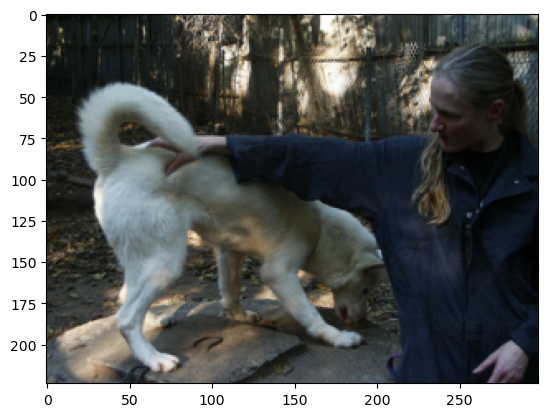

In [35]:
imgs, labels, masks, noise = next(iter(dloader))
show_imarray(imgs[0])

In [8]:
imgs = normalize_hw(imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


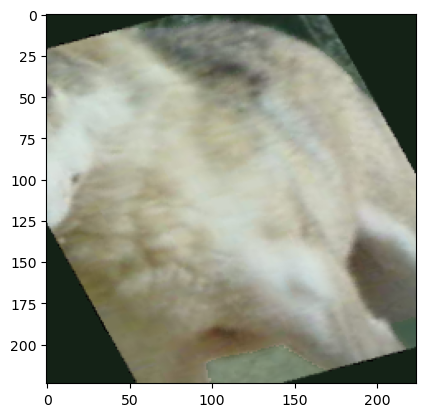

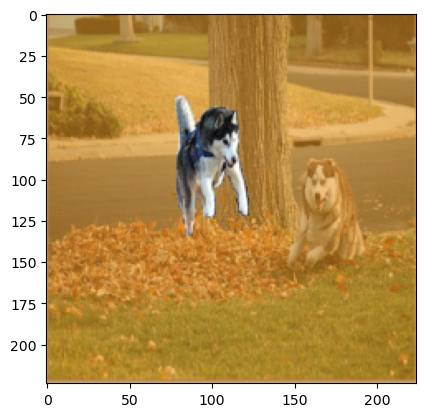

In [9]:
bs = imgs.size(0)
# alpha = (torch.randperm(bs).view(-1, 1, 1, 1) % bs + 1) / bs * 0.9 + 0.1
alpha = torch.rand(bs, 1, 1, 1) * 0.9 + 0.1
x = masks * imgs + ~masks * (
    alpha * torch.randn(masks.size(0), imgs.size(1), 1, 1) + (1 - alpha) * imgs
)
show_imarray(normalize_inv_hw(x[0]))
plt.show()
show_imarray(normalize_inv_hw(x[1]))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


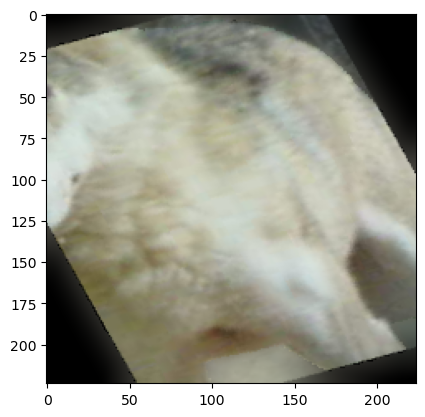

In [11]:
bs = imgs.size(0)
# alpha = (torch.randperm(bs).view(-1, 1, 1, 1) % bs + 1) / bs * 0.9 + 0.1
alpha = torch.rand(bs, 1, 1, 1) * 0.9 + 0.1
# alpha = torch.ones(bs, 1, 1, 1)
masks_inv = ~masks
# x = gaussian_blur(~masks * imgs, 21)
# x = masks * imgs + ~masks * x
x = masks * imgs + masks_inv * (
    alpha * gaussian_blur(masks_inv * imgs, 31, sigma=100) + (1 - alpha) * imgs
)
# x = ~masks * gaussian_blur(~masks * imgs, 103)
show_imarray(normalize_inv_hw(x[0]))
plt.show()
# alpha
# show_imarray(normalize_inv_hw(x[1]))
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


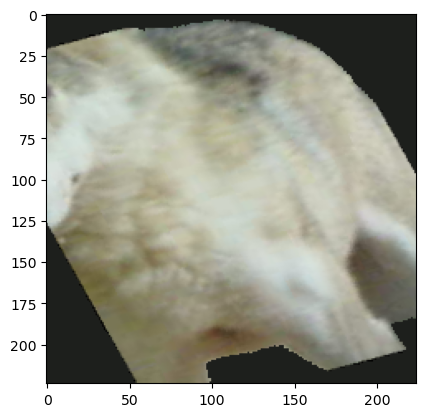

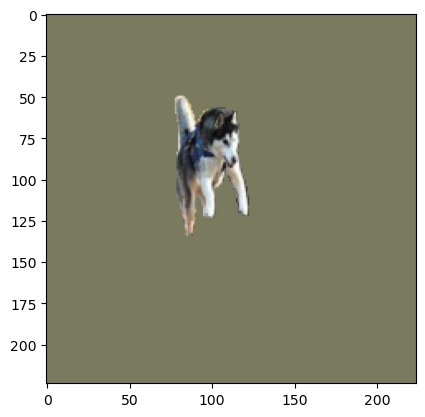

In [12]:
bs = imgs.size(0)
# alpha = (torch.randperm(bs).view(-1, 1, 1, 1) % bs + 1) / bs * 0.9 + 0.1
alpha = torch.rand(bs, 1, 1, 1) * 0.9 + 0.1

masks_inv = ~masks
x = masks * imgs + masks_inv * (
    (masks_inv * imgs).view(imgs.size(0), imgs.size(1), -1).sum(-1)
    / (masks_inv.view(masks.size(0), masks.size(1), -1).sum(-1))
).view(imgs.size(0), imgs.size(1), 1, 1)
show_imarray(normalize_inv_hw(x[0]))
plt.show()
show_imarray(normalize_inv_hw(x[1]))
plt.show()

In [13]:
%%timeit
x = masks * imgs + ~masks * gaussian_blur(imgs, 51)

645 ms ± 66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
x = masks * imgs + ~masks * (
    alpha * torch.randn(masks.size(0), imgs.size(1), 1, 1) + (1 - alpha) * imgs
)

9.58 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
# class Blur(nn.Module):
#     def __init__(self, alpha_range=(0.02, 1.0)) -> None:
#         super().__init__()
#         self.alpha_range = alpha_range

#     def get_alphas(self, size, high):
#         return 2 ** np.random.randint(5, high=high, size=size)
#         # return np.random.uniform(*self.alpha_range, size=size)

#     def forward(self, x):
#         h, w = x.size()[-2:]
#         d, m = divmod(x.size(0), 4)
#         return torch.concatenate(
#             [
#                 resize(
#                     resize(
#                         x[i * 4 : (i + 1) * 4],
#                         (h // alpha, w // alpha),
#                         antialias=False,
#                     ),
#                     (h, w),
#                 )
#                 for i, alpha in enumerate(
#                     self.get_alphas(d + bool(m), np.floor(np.log2(max(h, w))))
#                 )
#             ]
#         )
class Blur(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def get_alphas(self, size, high):
        return 2 ** np.random.randint(5, high=high, size=size)

    def forward(self, x):
        h, w = x.size()[-2:]
        d, m = divmod(x.size(0), 4)
        return torch.concatenate([
            resize(resize(x[i * 4:(i + 1) * 4], (max(h // alpha, 1), max(w // alpha, 1)), antialias=False), (h, w))
            for i, alpha in enumerate(self.get_alphas(d + bool(m), np.ceil(np.log2(max(h, w)))))]
        )

In [64]:
blur = Blur()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


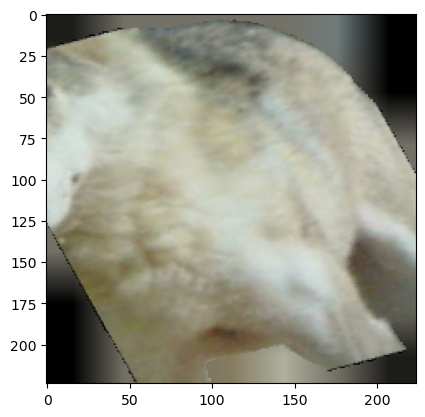

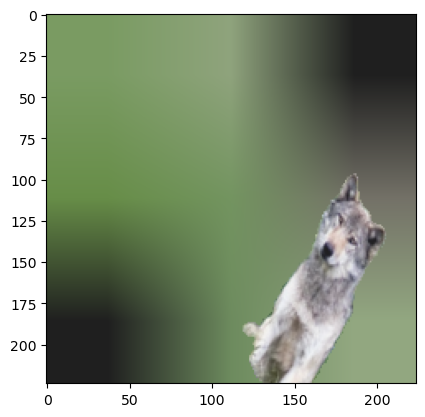

In [18]:
bs = imgs.size(0)
# alpha = (torch.randperm(bs).view(-1, 1, 1, 1) % bs + 1) / bs * 0.9 + 0.1
# alpha = torch.rand(bs, 1, 1, 1) * .9 + .1
alpha = torch.ones(bs, 1, 1, 1)

masks_inv = ~masks
x = masks * imgs + masks_inv * blur(masks_inv * imgs)
show_imarray(normalize_inv_hw(x[0]))
plt.show()
show_imarray(normalize_inv_hw(x[5]))
plt.show()

# Report

In [41]:
dloader = get_dloader("val", 1, data_dir=data_dir, noise=True)
dloader_iter = iter(dloader)

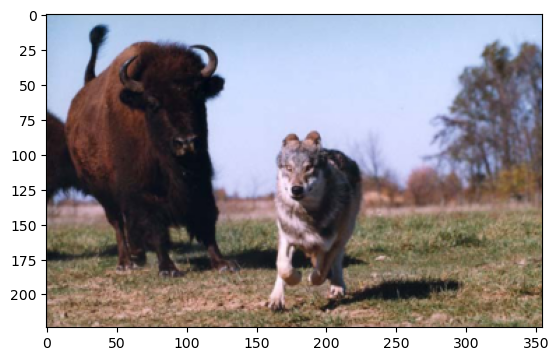

In [43]:
imgs, labels, masks, noise = next(dloader_iter)
show_imarray(imgs[0])

In [46]:
imgs = normalize_hw(imgs)

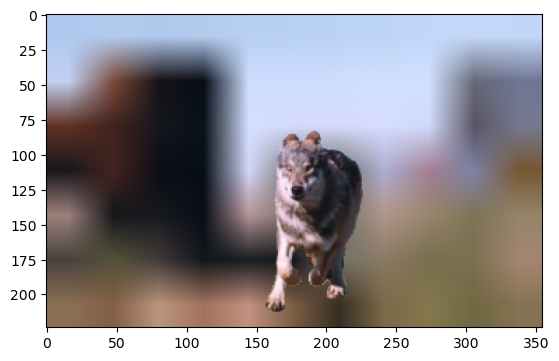

In [80]:
bs = imgs.size(0)
# alpha = (torch.randperm(bs).view(-1, 1, 1, 1) % bs + 1) / bs * 0.9 + 0.1
# alpha = torch.rand(bs, 1, 1, 1) * .9 + .1
alpha = torch.ones(bs, 1, 1, 1)

masks_inv = ~masks
x = masks * imgs + masks_inv * blur(masks_inv * imgs)
show_imarray(normalize_inv_hw(x[0]))
plt.show()
# show_imarray(normalize_inv_hw(x[5]))
# plt.show()

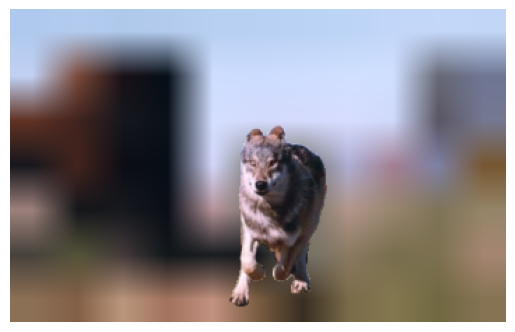

In [81]:
fig, ax = plt.subplots(1, 1)
show_imarray(normalize_inv_hw(x[0]), ax=ax)
ax.axis('off')
plt.savefig(f"{fig_dir}/blur_resize_example0.pdf", bbox_inches='tight')